In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorboard

In [2]:
mnist = keras.datasets.mnist.load_data()

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = mnist
# X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full)

In [4]:
X_val, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_val, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

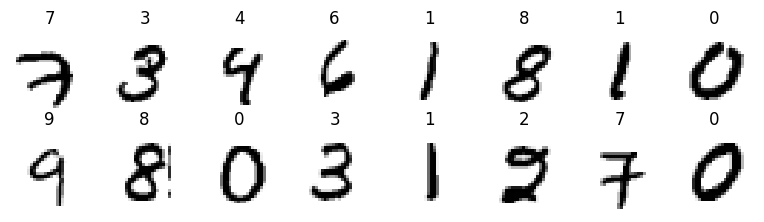

In [5]:
def plot_mnist(n_rows, n_cols, sample):
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(sample[index],cmap="binary", interpolation="nearest")
            plt.axis("off")
            plt.title(y_train[index],fontsize=12)
plot_mnist(2, 8, X_train)
plt.show()

In [6]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(keras.backend.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        keras.backend.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [7]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [10]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_val, y_val),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.5870 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

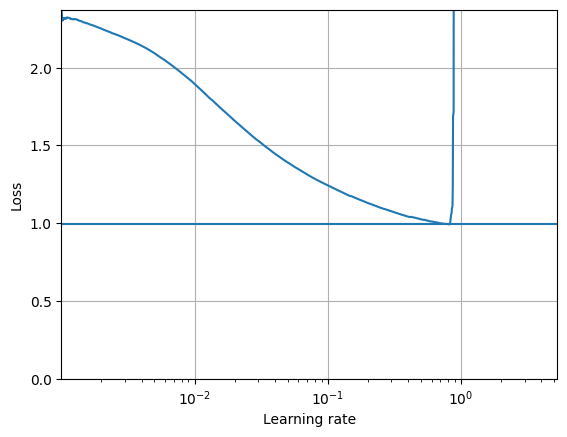

In [11]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [12]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(learning_rate=3e-1),
             metrics=["accuracy"])

In [15]:
run_index = 1
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))

In [16]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                   validation_data=(X_val, y_val),
                   callbacks=[early_stopping_cb, checkpoint_cb, tensorboard])

Epoch 1/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2387 - accuracy: 0.9257 - val_loss: 0.1048 - val_accuracy: 0.9702
Epoch 2/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0977 - accuracy: 0.9695 - val_loss: 0.0978 - val_accuracy: 0.9728
Epoch 3/100
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0659 - accuracy: 0.9793 - val_loss: 0.0792 - val_accuracy: 0.9782
Epoch 4/100
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0496 - accuracy: 0.9839 - val_loss: 0.0869 - val_accuracy: 0.9766
Epoch 5/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0357 - accuracy: 0.9882 - val_loss: 0.0898 - val_accuracy: 0.9744
Epoch 6/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0290 - accuracy: 0.9905 - val_loss: 0.0734 - val_accuracy: 0.9810
Epoch 7/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0812 - val_ac

In [17]:
model = keras.models.load_model("my_mnist_model.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.0780 - accuracy: 0.9797


[0.07799788564443588, 0.9797000288963318]

In [18]:
# %load_ext tensorboard
# %tensorboard --logdir=./my_mnist_logs --port=6006